# H12.1 Value functions for mazes

## (a)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_maze(filepath):
    out = []
    with open(filepath) as file:
        skip = True
        maze_row = 0
        maze_nr = 0
        for line in file:
            row = line.rstrip()
            if (len(row) > 0):
                if (skip):
                    out.append([[]])
                    maze_nr += 1
                    maze_row += 1
                else:
                    out[maze_nr - 1].append([])
                    maze_row += 1
                skip = False
            else:
                maze_row = 0
                skip = True
            for c in row:
                out[maze_nr - 1][maze_row - 1].append(c)
    return np.array(out)

def plot_maze(maze, ax, states=None, normed_vf=None):
    rows, columns = maze.shape
    im = np.ones((rows, columns, 3))
    if states is not None and normed_vf is not None:
        min_val = np.amin(normed_vf)
        val_range = np.amax(normed_vf) - min_val
        index = 0
        normed_vf = (normed_vf - min_val)/val_range
        for v in normed_vf:
            row_index = states[index][1]
            column_index = states[index][2]
            im[row_index][column_index] = [1-v, 1, 1-v]
            index += 1
    for i in range(rows):
        for j in range(columns):
            if(maze[i][j] == '#'):
                # wall
                im[i][j] = [0, 0, 0]
            elif(maze[i][j] == 'X'):
                # reward
                ax.text(j-0.3, i+0.3, maze[i][j])
                im[i][j] = [0, 1, 0]
            elif(maze[i][j] != ' '):
                # dir
                ax.text(j, i, maze[i][j])
#                 im[i][j] = [1, 1, 1]
    return im

(6, 20, 20)


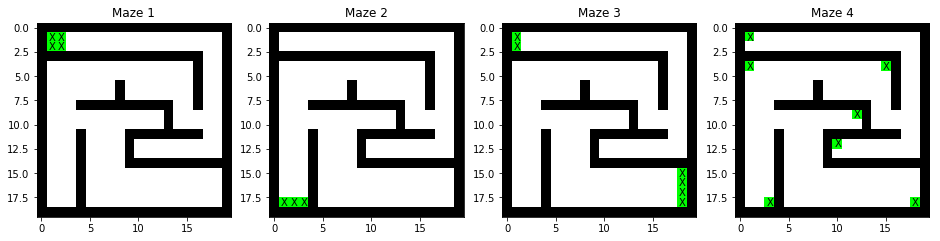

In [3]:
mazes = read_maze('mazes.txt')
print mazes.shape

fig, axs = plt.subplots(1, 4, figsize=(16,24))
ax_index = 0
for maze in mazes[:4]:
    ax = axs[ax_index]
    ax.set_title('Maze ' + str(ax_index+1))
    im = plot_maze(maze, ax)
    im = ax.imshow(im)
    ax_index += 1
plt.show()

## (b)

In [4]:
def get_states(maze):
    rows, columns = maze.shape
    states = []
    index = 0
    for i in range(rows):
        for j in range(columns):
            if maze[i][j] != '#':
                states += [[index, i, j]]
                index += 1
    return np.array(states)

def move(src, action):
    if(action == 'right'):
        return [src[0], src[1]+1]
    elif (action == 'down'):
        return [src[0] + 1, src[1]]
    elif (action == 'left'):
        return [src[0], src[1] - 1]
    elif (action == 'up'):
        return [src[0] - 1, src[1]]
    
def check_move_eligibility(src, dest, action):
    after_move = move(src, action)
    if(dest[0] == src[0] and dest[1] == src[1]):
        if(maze[after_move[0]][after_move[1]] == '#'):
            return 1.0
    return (dest[0] == after_move[0] and dest[1] == after_move[1]) + 0.0

def gen_transition_model(maze, states, actions):
    S = states.shape[0]
    A = actions.shape[0]
    P = np.zeros((S, S, A))
    for i in range(S):
        src = states[i][1:3]
        for j in range(S):
            dest = states[j][1:3]
            for k in range(A):
#                 print src
                P[i,j,k] = check_move_eligibility(src, dest, actions[k])
    return P           
    

In [5]:
actions = np.array(['right', 'down', 'left', 'up'])
P = []
for maze in mazes[:4]:
    states = get_states(maze)
    P += [gen_transition_model(maze, states, actions)]

## (c)

In [6]:
def uniform_policy(states,actions):
    S = states.shape[0]
    A = actions.shape[0]
    policy = np.full((A, S), 1.0/A)
    return policy

def reward(maze, states, actions):
    S = states.shape[0]
    A = actions.shape[0]
    Rewards = np.zeros((A, S))
    for i in range(A):
        for j in range(S):
            row_index = states[j][1]
            column_index = states[j][2]
            if(maze[row_index][column_index] == 'X'):
                Rewards[i][j] = 1
    return Rewards
def analytic_value_func(rewards, P, policy, discount):
    controlled_rewards = np.sum(rewards*policy, axis=0)
    controlled_transition = np.sum(np.transpose(P,(1,0,2)) * np.transpose(policy, (1,0)), axis=2)
#     print controlled_transition.shape
    B = np.dot(np.linalg.inv((np.identity(controlled_rewards.size)-discount*controlled_transition)), controlled_rewards)
    return B

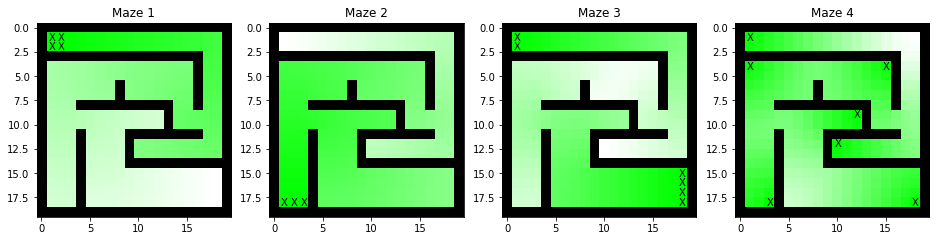

In [7]:
discount_factor = 0.9
fig, axs = plt.subplots(1, 4, figsize=(16,24))
ax_index = 0
for maze in mazes[:4]:
    states = get_states(maze)
    rewards = reward(maze, states, actions)
    P = gen_transition_model(maze, states, actions)
    policy = uniform_policy(states, actions)
    v = analytic_value_func(rewards, P, policy, discount_factor)
    v = np.log(v)
    ax = axs[ax_index]
    ax.set_title('Maze ' + str(ax_index+1))
    im = plot_maze(maze, ax, states, v)
    im = ax.imshow(im)
    ax_index += 1
#     print vf.shape
plt.show()

## (d)

# H12.2  Find a good policy

## (a)

In [8]:
def direction_equal(action, dir):
    right = (action == 'right' and dir=='>') 
    left = (action == 'left' and dir=='<') 
    up = (action == 'up' and dir=='^') 
    down = (action == 'down' and dir=='v')
    return (right or left or up or down) + 1e-35  # avoid 0

def new_policy(maze, states,actions):
    S = states.shape[0]
    A = actions.shape[0]
    policy = np.zeros((A, S))
    for i in range(A):
        for j in range(S):
            row_index = states[j][1]
            column_index = states[j][2]
            if(maze[row_index][column_index] == 'X' or maze[row_index][column_index] == ' '):
                policy[i][j] = 1.0/A
            else:
                policy[i][j] = direction_equal(actions[i], maze[row_index][column_index])
    return policy

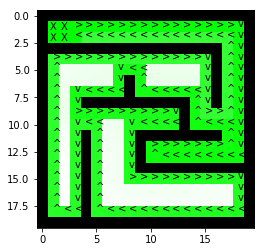

In [9]:
maze = mazes[4]
discount_factor = 0.9
ax = plt.subplot()
ax_index = 0
states = get_states(maze)
rewards = reward(maze, states, actions)
P = gen_transition_model(maze, states, actions)
policy = new_policy(maze, states, actions)
v = analytic_value_func(rewards, P, policy, discount_factor)
v = np.log(v)
im = plot_maze(maze, ax, states, v)
im = ax.imshow(im)
plt.show()

## (b)

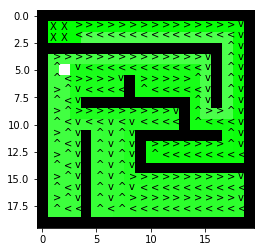

In [10]:
maze = mazes[5]
discount_factor = 0.9
ax = plt.subplot()
ax_index = 0
states = get_states(maze)
rewards = reward(maze, states, actions)
P = gen_transition_model(maze, states, actions)
policy = new_policy(maze, states, actions)
v = analytic_value_func(rewards, P, policy, discount_factor)
v = np.log(v)
im = plot_maze(maze, ax, states, v)
im = ax.imshow(im)
plt.show()